In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from collections import Counter
import math
import random

#%matplotlib inline

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from imblearn.over_sampling import RandomOverSampler, SMOTE

#### Helper Functions

In [4]:
def label_encoding_func(df_name, df_col_name):
    '''
    usage: dataframe[column_name] = label_encoding_function(dataframe, column_name)
    '''
    le = preprocessing.LabelEncoder()
    le.fit(df_name[df_col_name])
    return le.transform(df_name[df_col_name])

In [5]:
def do_one_hot_encoding(df_name, df_column_name, suffix=''):
    '''
    usage: dataframe[column_name] = do_one_hot_encoding(dataframe, column_name, suffix_for_column_name)
    '''
    x = pd.get_dummies(df_name[df_column_name])
    df_name = df_name.join(x, lsuffix=suffix)
    df_name = df_name.drop(df_column_name, axis=1) 
    return df_name

#### Load Data

In [1]:
path = '../../feature_engineering_eda_data/' 
train_file = 'train_feature_engineered_V2.csv'
test_file = 'test_feature_engineered_V2.csv'

In [4]:
train_df = pd.read_csv(path+train_file)
test_df = pd.read_csv(path+test_file)
sample_submission = pd.read_csv(path+'sample_submission_24jSKY6.csv')

In [5]:
print(train_df.shape)
print(test_df.shape)

(233154, 55)
(112392, 54)


#### Sample Data

In [99]:
pd.set_option('display.max_columns', 100)

In [100]:
train_df.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default,F1_Manual_LTV,F2_difference_asset_disbursed,F3_avg_primary_sanctioned_amt,F4_avg_primary_disbursed_amt,F5_ratio_primary_active_overdue,F6_age_at_disbursal,F7.1_DOB_Y,F7.2_DOB_M,F7.3_DOB_D,F8.1_DisDate_Y,F8.2_DisDate_M,F8.3_DisDate_D,F9.1_AVG.ACCT.AGE_Y,F9.2_AVG.ACCT.AGE_M,F10.1_CREDIT.HIST_Y,F10.2_CREDIT.HIST_M
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,86.606164,7822,0.0,0.0,0.0,34.610959,1984,1,1,2018,8,3,0,0,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,0,1,71.922197,18405,50200.0,50200.0,1.0,33.178082,1985,7,31,2018,9,26,1,11,1,11
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,86.828553,8082,0.0,0.0,0.0,32.958904,1985,8,24,2018,8,1,0,0,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,1,1,86.991968,8600,0.0,0.0,0.0,24.838356,1993,12,30,2018,10,26,0,8,1,3
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,86.862355,7922,0.0,0.0,0.0,40.824658,1977,12,9,2018,9,26,0,0,0,0


In [101]:
test_df.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,F1_Manual_LTV,F2_difference_asset_disbursed,F3_avg_primary_sanctioned_amt,F4_avg_primary_disbursed_amt,F5_ratio_primary_active_overdue,F6_age_at_disbursal,F7.1_DOB_Y,F7.2_DOB_M,F7.3_DOB_D,F8.1_DisDate_Y,F8.2_DisDate_M,F8.3_DisDate_D,F9.1_AVG.ACCT.AGE_Y,F9.2_AVG.ACCT.AGE_M,F10.1_CREDIT.HIST_Y,F10.2_CREDIT.HIST_M
0,655269,53478,63558,86.54,67,22807,45,1497,01-01-74,Salaried,03-11-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,84.140470,10080,0.0,0.0,0.0,44.868493,1974,1,1,2018,11,3,0,0,0,0
1,723482,55513,63163,89.45,67,22807,45,1497,20-05-85,Self employed,20-11-18,6,1998,1,1,0,0,0,0,749,C-Very Low Risk,2,1,0,43898,48780,48780,0,0,0,0,0,0,5605,0,1,0,1,87.888479,7650,24390.0,24390.0,0.0,33.526027,1985,5,20,2018,11,20,0,8,1,0
2,758529,65282,84320,79.93,78,23135,86,2071,14-10-95,Salaried,29-11-18,4,1646,1,1,1,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,77.421727,19038,0.0,0.0,0.0,23.142466,1995,10,14,2018,11,29,0,0,0,0
3,763449,46905,63896,76.58,78,17014,45,2070,01-06-73,Self employed,29-11-18,4,1646,1,1,0,0,0,0,14,Not Scored: Only a Guarantor,1,1,1,132480,255000,255000,0,0,0,0,0,0,0,0,0,0,0,73.408351,16991,255000.0,255000.0,1.0,45.526027,1973,6,1,2018,11,29,2,5,2,5
4,708663,51428,63896,86.08,78,17014,45,2069,01-06-72,Salaried,17-11-18,4,1646,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,80.487041,12468,0.0,0.0,0.0,46.493151,1972,6,1,2018,11,17,0,0,0,0


## Data Cleaning / Exploration

#### Distribution of Target

0    0.782929
1    0.217071
Name: loan_default, dtype: float64


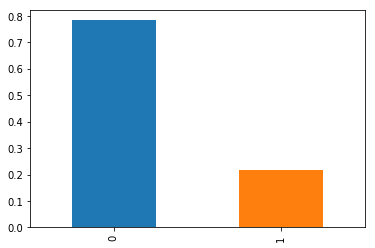

In [102]:
print(train_df['loan_default'].value_counts()/sum(train_df['loan_default'].value_counts()))
(train_df['loan_default'].value_counts()/sum(train_df['loan_default'].value_counts())).plot(kind='bar')
plt.show()

#### Remove cols from train and test and separate target

In [103]:
cols_to_exclude = ['loan_default', 'UniqueID', 'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS',
                  'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT', 
                  'MobileNo_Avl_Flag', 'Passport_flag', 'Driving_flag']

X_train = train_df[train_df.columns.difference(cols_to_exclude)]
X_test = test_df[test_df.columns.difference(cols_to_exclude)]
Y = train_df['loan_default']

In [104]:
### Concat train and test for common preprocessing
concat_df = pd.concat([X_train, X_test], keys=['train', 'test'])

In [105]:
concat_df.head()

Aadhar_flag  Current_pincode_ID  DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS  \
train 0            1                1441                                    0   
      1            1                1502                                    1   
      2            1                1497                                    0   
      3            1                1501                                    0   
      4            1                1495                                    0   

        Date.of.Birth DisbursalDate  Employee_code_ID Employment.Type  \
train 0      01-01-84      03-08-18              1998        Salaried   
      1      31-07-85      26-09-18              1998   Self employed   
      2      24-08-85      01-08-18              1998   Self employed   
      3      30-12-93      26-10-18              1998   Self employed   
      4      09-12-77      26-09-18              1998   Self employed   

         F10.1_CREDIT.HIST_Y  F10.2_CREDIT.HIST_M  F1_Manual_LTV  \
train 0                    0                    0      86.606164   
      1                    1                   11      71.922197   
      2                    0                    0      86.828553   
      3                    1                    3      86.991968   
      4                    0                    0      86.862355   

         F2_difference_asset_disbursed  F3_avg_primary_sanctioned_amt  \
train 0                           7822                            0.0   
      1                          18405                        50200.0   
      2                           8082                            0.0   
      3                           8600                            0.0   
      4                           7922                            0.0   

         F4_avg_primary_disbursed_amt  F5_ratio_primary_active_overdue  \
train 0                           0.0                              0.0   
      1                       50200.0                              1.0   
      2                           0.0                              0.0   
      3                           0.0                              0.0   
      4                           0.0                              0.0   

         F6_age_at_disbursal  F7.1_DOB_Y  F7.2_DOB_M  F7.3_DOB_D  \
train 0            34.610959        1984           1           1   
      1            33.178082        1985           7          31   
      2            32.958904        1985           8          24   
      3            24.838356        1993          12          30   
      4            40.824658        1977          12           9   

         F8.1_DisDate_Y  F8.2_DisDate_M  F8.3_DisDate_D  F9.1_AVG.ACCT.AGE_Y  \
train 0            2018               8               3                    0   
      1            2018               9              26                    1   
      2            2018               8               1                    0   
      3            2018              10              26                    0   
      4            2018               9              26                    0   

         F9.2_AVG.ACCT.AGE_M  NEW.ACCTS.IN.LAST.SIX.MONTHS  NO.OF_INQUIRIES  \
train 0                    0                             0                0   
      1                   11                             0                0   
      2                    0                             0                0   
      3                    8                             0                1   
      4                    0                             0                1   

         PAN_flag  PERFORM_CNS.SCORE PERFORM_CNS.SCORE.DESCRIPTION  \
train 0         0                  0   No Bureau History Available   
      1         0                598                 I-Medium Risk   
      2         0                  0   No Bureau History Available   
      3         0                305              L-Very High Risk   
      4         0                  0   No Bureau History Available   

    

#### Check for nulls

In [106]:
concat_df.isna().sum(axis=0).reset_index().T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44
index,Aadhar_flag,Current_pincode_ID,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,Date.of.Birth,DisbursalDate,Employee_code_ID,Employment.Type,F10.1_CREDIT.HIST_Y,F10.2_CREDIT.HIST_M,F1_Manual_LTV,F2_difference_asset_disbursed,F3_avg_primary_sanctioned_amt,F4_avg_primary_disbursed_amt,F5_ratio_primary_active_overdue,F6_age_at_disbursal,F7.1_DOB_Y,F7.2_DOB_M,F7.3_DOB_D,F8.1_DisDate_Y,F8.2_DisDate_M,F8.3_DisDate_D,F9.1_AVG.ACCT.AGE_Y,F9.2_AVG.ACCT.AGE_M,NEW.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,PAN_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.ACTIVE.ACCTS,PRI.CURRENT.BALANCE,PRI.DISBURSED.AMOUNT,PRI.NO.OF.ACCTS,PRI.OVERDUE.ACCTS,PRI.SANCTIONED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,SEC.NO.OF.ACCTS,State_ID,VoterID_flag,asset_cost,branch_id,disbursed_amount,ltv,manufacturer_id,supplier_id
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [107]:
#### replace nulls as a new category
concat_df['Employment.Type'].fillna('NA', inplace=True)

#### Some New Features

In [108]:
concat_df['employee_id_branch_id'] = concat_df['branch_id'].apply(str)+"-"+concat_df['Employee_code_ID'].apply(str)

#### Label encode strings

In [109]:
def label_encode_apply(df):
    if df[0] == object:
        print(df['index'])
        concat_df[df['index']] = label_encoding_func(concat_df, df['index'])
        
_ = concat_df.dtypes.reset_index().apply(label_encode_apply, axis=1)
print('Done')

Date.of.Birth
DisbursalDate
Employment.Type
PERFORM_CNS.SCORE.DESCRIPTION
employee_id_branch_id
Done


In [110]:
concat_df.head()

Aadhar_flag  Current_pincode_ID  DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS  \
train 0            1                1441                                    0   
      1            1                1502                                    1   
      2            1                1497                                    0   
      3            1                1501                                    0   
      4            1                1495                                    0   

         Date.of.Birth  DisbursalDate  Employee_code_ID  Employment.Type  \
train 0             30              2              1998                1   
      1          15744             90              1998                2   
      2          12399              0              1998                2   
      3          15581             91              1998                2   
      4           4755             90              1998                2   

         F10.1_CREDIT.HIST_Y  F10.2_CREDIT.HIST_M  F1_Manual_LTV  \
train 0                    0                    0      86.606164   
      1                    1                   11      71.922197   
      2                    0                    0      86.828553   
      3                    1                    3      86.991968   
      4                    0                    0      86.862355   

         F2_difference_asset_disbursed  F3_avg_primary_sanctioned_amt  \
train 0                           7822                            0.0   
      1                          18405                        50200.0   
      2                           8082                            0.0   
      3                           8600                            0.0   
      4                           7922                            0.0   

         F4_avg_primary_disbursed_amt  F5_ratio_primary_active_overdue  \
train 0                           0.0                              0.0   
      1                       50200.0                              1.0   
      2                           0.0                              0.0   
      3                           0.0                              0.0   
      4                           0.0                              0.0   

         F6_age_at_disbursal  F7.1_DOB_Y  F7.2_DOB_M  F7.3_DOB_D  \
train 0            34.610959        1984           1           1   
      1            33.178082        1985           7          31   
      2            32.958904        1985           8          24   
      3            24.838356        1993          12          30   
      4            40.824658        1977          12           9   

         F8.1_DisDate_Y  F8.2_DisDate_M  F8.3_DisDate_D  F9.1_AVG.ACCT.AGE_Y  \
train 0            2018               8               3                    0   
      1            2018               9              26                    1   
      2            2018               8               1                    0   
      3            2018              10              26                    0   
      4            2018               9              26                    0   

         F9.2_AVG.ACCT.AGE_M  NEW.ACCTS.IN.LAST.SIX.MONTHS  NO.OF_INQUIRIES  \
train 0                    0                             0                0   
      1                   11                             0                0   
      2                    0                             0                0   
      3                    8                             0                1   
      4                    0                             0                1   

         PAN_flag  PERFORM_CNS.SCORE  PERFORM_CNS.SCORE.DESCRIPTION  \
train 0         0                  0                             13   
      1         0                598                              8   
      2         0                  0                             13   
      3         0                305                             11   
      4         0                  0                

#### Separate train and test

In [111]:
X_train = concat_df.loc['train']
X_test = concat_df.loc['test']

In [112]:
print(X_train.shape)
print(X_test.shape)

(233154, 46)
(112392, 46)


In [134]:
50/107

0.4672897196261682

#### FE Functions

In [119]:
### this function is for running inside cv

def generate_summed_features(train, val, test, variable=''):
    '''
    function to generate new features inside cv
    '''
    pincode = train.groupby('Current_pincode_ID')[variable].sum().reset_index()
    state = train.groupby('State_ID')[variable].sum().reset_index()
    supplier = train.groupby('supplier_id')[variable].sum().reset_index()
    branch = train.groupby('branch_id')[variable].sum().reset_index()
    
    list_of_dfs = [train, val, test]
    
    for i in range(len(list_of_dfs)):
        list_of_dfs[i] = pd.merge(list_of_dfs[i], pincode, how='left', on='Current_pincode_ID', 
         suffixes=('', '_sum_pincode_F11.1'))
        list_of_dfs[i] = pd.merge(list_of_dfs[i], state, how='left', on='State_ID', 
         suffixes=('', '_sum_state_F11.2'))
        list_of_dfs[i] = pd.merge(list_of_dfs[i], supplier, how='left', on='supplier_id', 
         suffixes=('', '_sum_supplier_F11.3'))
        list_of_dfs[i] = pd.merge(list_of_dfs[i], branch, how='left', on='branch_id', 
         suffixes=('', '_sum_branch_F11.4'))
        
        list_of_dfs[i].fillna(0, inplace=True)
        
    train, val, test = list_of_dfs[0], list_of_dfs[1], list_of_dfs[2]    
    return train, val, test  


#### this function is for running inside cv

def generate_averaged_features(train, val, test, variable=''):
    '''
    function to generate new features inside cv
    '''
    pincode = train.groupby('Current_pincode_ID')[variable].mean().reset_index()
    branch = train.groupby('branch_id')[variable].mean().reset_index()
    employee_code_id = train.groupby('Employee_code_ID')[variable].mean().reset_index()
    employee_code_id_branch_id = train.groupby('employee_id_branch_id')[variable].mean().reset_index()
    supplier_id = train.groupby('supplier_id')[variable].mean().reset_index()

    list_of_dfs = [train, val, test]
    
    for i in range(len(list_of_dfs)):
        list_of_dfs[i] = pd.merge(list_of_dfs[i], pincode, how='left', on='Current_pincode_ID', 
         suffixes=('', '_mean_pincode_F13.1'))
        list_of_dfs[i] = pd.merge(list_of_dfs[i], branch, how='left', on='branch_id', 
         suffixes=('', '_mean_branch_F13.2'))
        list_of_dfs[i] = pd.merge(list_of_dfs[i], employee_code_id, how='left', on='Employee_code_ID', 
         suffixes=('', '_mean_employeeid_F13.3'))
        list_of_dfs[i] = pd.merge(list_of_dfs[i], employee_code_id_branch_id, how='left', on='employee_id_branch_id', 
         suffixes=('', '_mean_employee_id_branch_id_F13.4'))
        list_of_dfs[i] = pd.merge(list_of_dfs[i], supplier_id, how='left', on='supplier_id', 
         suffixes=('', '_mean_supplier_id_F13.5'))
        
        list_of_dfs[i].fillna(0, inplace=True)
        
    train, val, test = list_of_dfs[0], list_of_dfs[1], list_of_dfs[2]    
    return train, val, test  

In [120]:
X_train.columns.values

array(['Aadhar_flag', 'Current_pincode_ID',
       'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'Date.of.Birth',
       'DisbursalDate', 'Employee_code_ID', 'Employment.Type',
       'F10.1_CREDIT.HIST_Y', 'F10.2_CREDIT.HIST_M', 'F1_Manual_LTV',
       'F2_difference_asset_disbursed', 'F3_avg_primary_sanctioned_amt',
       'F4_avg_primary_disbursed_amt', 'F5_ratio_primary_active_overdue',
       'F6_age_at_disbursal', 'F7.1_DOB_Y', 'F7.2_DOB_M', 'F7.3_DOB_D',
       'F8.1_DisDate_Y', 'F8.2_DisDate_M', 'F8.3_DisDate_D',
       'F9.1_AVG.ACCT.AGE_Y', 'F9.2_AVG.ACCT.AGE_M',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'NO.OF_INQUIRIES', 'PAN_flag',
       'PERFORM_CNS.SCORE', 'PERFORM_CNS.SCORE.DESCRIPTION',
       'PRI.ACTIVE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.DISBURSED.AMOUNT',
       'PRI.NO.OF.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.SANCTIONED.AMOUNT',
       'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT', 'SEC.NO.OF.ACCTS',
       'State_ID', 'VoterID_flag', 'asset_cost', 'branch_id',
       'disbursed_amou

## Baseline Model Building

In [121]:
strf_split = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [136]:
val_auc_scores = []
test_preds_list = []
all_train_predictions = np.zeros([X_train.shape[0]])

cv_counter = 1

for train_idx, val_idx in strf_split.split(X_train, Y):
    print("***************** ", cv_counter, " *****************", end="\n\n")
    
    t_x = X_train.iloc[train_idx]
    v_x = X_train.iloc[val_idx]
    
    t_y = Y[train_idx]
    v_y = Y[val_idx]
    
    
    test_x = X_test.copy()

    #generate new features
    t_x, v_x, test_x = generate_averaged_features(t_x, v_x, test_x, 'ltv')
    t_x, v_x, test_x = generate_averaged_features(t_x, v_x, test_x, 'PRI.CURRENT.BALANCE')
    t_x, v_x, test_x = generate_averaged_features(t_x, v_x, test_x, 'disbursed_amount')
    t_x, v_x, test_x = generate_averaged_features(t_x, v_x, test_x, 'asset_cost')
    t_x, v_x, test_x = generate_averaged_features(t_x, v_x, test_x, 'PRIMARY.INSTAL.AMT')
    t_x, v_x, test_x = generate_averaged_features(t_x, v_x, test_x, 'PERFORM_CNS.SCORE')
    t_x, v_x, test_x = generate_averaged_features(t_x, v_x, test_x, 'F4_avg_primary_disbursed_amt')
    t_x, v_x, test_x = generate_averaged_features(t_x, v_x, test_x, 'F2_difference_asset_disbursed')
    t_x, v_x, test_x = generate_averaged_features(t_x, v_x, test_x, 'PRI.NO.OF.ACCTS')
    
    
    t_x, v_x, test_x = generate_summed_features(t_x, v_x, test_x, 'PRI.ACTIVE.ACCTS')
    t_x, v_x, test_x = generate_summed_features(t_x, v_x, test_x, 'PRI.OVERDUE.ACCTS')
    t_x, v_x, test_x = generate_summed_features(t_x, v_x, test_x, 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS')
    t_x, v_x, test_x = generate_summed_features(t_x, v_x, test_x, 'NO.OF_INQUIRIES')
    
    
    print("Train Shape: ", t_x.shape)
    print("Val Shape: ", v_x.shape)
    print("Test Shape: ", test_x.shape, end="\n\n")
    
    
    
    
    params = {}
    params['learning_rate'] = 0.009
    params['boosting_type'] = 'gbdt'
    params['objective'] = 'binary'
    params['metric'] = 'auc'
    params['feature_fraction'] = 0.4
    params['bagging_freq'] = 5
    params['bagging_fraction'] = 0.38
    params['num_leaves'] = 1000
    params['min_data_in_leaf'] = 80
    params['max_depth'] = 35
    params['num_threads'] = 20
    params['tree_learner'] = 'serial'
    params['min_sum_hessian_in_leaf'] = 0.001
    params['boost_from_average'] = False
    params['lambda_l1'] = 9
    params['lambda_l2'] = 5
    
    
    d_train = lgb.Dataset(t_x, label=t_y)
    d_valid = lgb.Dataset(v_x, label=v_y)
    
    
    model = lgb.train(params, d_train, 3000, early_stopping_rounds=300, valid_sets=[d_train, d_valid], 
                         verbose_eval=50)
    
   
    
    val_preds = model.predict(v_x)
    val_score = roc_auc_score(v_y, val_preds)
    
    all_train_predictions[val_idx] = val_preds
    
    print(val_score)
    
    val_auc_scores.append(val_score)
    
        
    test_preds = model.predict(test_x)
    test_preds_list.append(test_preds)
    
    cv_counter+=1
    
    print("============"*8, end="\n\n")

*****************  1  *****************

Train Shape:  (209837, 107)
Val Shape:  (23317, 107)
Test Shape:  (112392, 107)

Training until validation scores don't improve for 300 rounds.
[50]	training's auc: 0.652958	valid_1's auc: 0.654276
[100]	training's auc: 0.662825	valid_1's auc: 0.660398
[150]	training's auc: 0.671981	valid_1's auc: 0.664894
[200]	training's auc: 0.681307	valid_1's auc: 0.668413
[250]	training's auc: 0.690894	valid_1's auc: 0.672016
[300]	training's auc: 0.69998	valid_1's auc: 0.674622
[350]	training's auc: 0.70908	valid_1's auc: 0.676805
[400]	training's auc: 0.71752	valid_1's auc: 0.679029
[450]	training's auc: 0.725542	valid_1's auc: 0.680619
[500]	training's auc: 0.732908	valid_1's auc: 0.682044
[550]	training's auc: 0.739898	valid_1's auc: 0.68322
[600]	training's auc: 0.746353	valid_1's auc: 0.684295
[650]	training's auc: 0.752752	valid_1's auc: 0.685138
[700]	training's auc: 0.7588	valid_1's auc: 0.686028
[750]	training's auc: 0.764734	valid_1's auc: 0.6864

[150]	training's auc: 0.673471	valid_1's auc: 0.65177
[200]	training's auc: 0.682414	valid_1's auc: 0.65476
[250]	training's auc: 0.692339	valid_1's auc: 0.657968
[300]	training's auc: 0.701481	valid_1's auc: 0.660455
[350]	training's auc: 0.710611	valid_1's auc: 0.662447
[400]	training's auc: 0.718648	valid_1's auc: 0.664358
[450]	training's auc: 0.726219	valid_1's auc: 0.665887
[500]	training's auc: 0.733718	valid_1's auc: 0.667469
[550]	training's auc: 0.740541	valid_1's auc: 0.668557
[600]	training's auc: 0.747153	valid_1's auc: 0.669599
[650]	training's auc: 0.753363	valid_1's auc: 0.670331
[700]	training's auc: 0.759592	valid_1's auc: 0.670899
[750]	training's auc: 0.765387	valid_1's auc: 0.671314
[800]	training's auc: 0.771204	valid_1's auc: 0.671831
[850]	training's auc: 0.77644	valid_1's auc: 0.672108
[900]	training's auc: 0.781792	valid_1's auc: 0.672299
[950]	training's auc: 0.786837	valid_1's auc: 0.672598
[1000]	training's auc: 0.791555	valid_1's auc: 0.67273
[1050]	traini

0.6865023528986682

*****************  9  *****************

Train Shape:  (209839, 107)
Val Shape:  (23315, 107)
Test Shape:  (112392, 107)

Training until validation scores don't improve for 300 rounds.
[50]	training's auc: 0.653914	valid_1's auc: 0.640782
[100]	training's auc: 0.662922	valid_1's auc: 0.646858
[150]	training's auc: 0.671882	valid_1's auc: 0.652259
[200]	training's auc: 0.681443	valid_1's auc: 0.657418
[250]	training's auc: 0.691034	valid_1's auc: 0.661103
[300]	training's auc: 0.700581	valid_1's auc: 0.664946
[350]	training's auc: 0.709239	valid_1's auc: 0.667629
[400]	training's auc: 0.717552	valid_1's auc: 0.670069
[450]	training's auc: 0.725374	valid_1's auc: 0.671631
[500]	training's auc: 0.732562	valid_1's auc: 0.673074
[550]	training's auc: 0.73958	valid_1's auc: 0.674402
[600]	training's auc: 0.746259	valid_1's auc: 0.675454
[650]	training's auc: 0.752564	valid_1's auc: 0.676041
[700]	training's auc: 0.758648	valid_1's auc: 0.676531
[750]	training's auc: 0.764

In [137]:
print("CV Score: ", np.mean(val_auc_scores))

CV Score:  0.6812681917617823


In [139]:
### Combine all CV preds for test
test_preds_cv = pd.DataFrame(np.asarray(test_preds_list).T).mean(axis=1).values

In [140]:
### train predictions

train_preds_cv = pd.DataFrame({
    'UniqueID': train_df['UniqueID'].values,
    'TrainPreds': all_train_predictions
})

train_preds_cv.head()

,UniqueID,TrainPreds
0,420825,0.383791
1,537409,0.377404
2,417566,0.468578
3,624493,0.558143
4,539055,0.358780


#### Prep Submission

In [142]:
sample_submission['loan_default'] = test_preds_cv

sample_submission.head()

,UniqueID,loan_default
0,655269,0.330128
1,723482,0.403047
2,758529,0.318913
3,763449,0.330359
4,708663,0.265885


In [143]:
sample_submission.to_csv('lgb4.csv', index=False)
#train_preds_cv.to_csv('LGB_FE_2_InsideCV_10foldCV_19thApril_2_TRAIN.csv', index=False)